# Background of the competition

Our task is to predict a string that is the [IUPAC International Chemical Identifier (InChI)](https://en.wikipedia.org/wiki/International_Chemical_Identifier) notation for a molecule from an image of that molecule. Even if you took high school chemistry, you are probably not familiar with InChI (I certainly wasn't). So, I'll outline a few important things about it.

As you will see, it might be better to think of the standard InChI string as 7 separate strings (sometimes some are empty) that are related (that need to be consistent with each other, which one can check automatically). I.e. in a sense there are 7 prediction targets that describe different properties of the molecule, but they are closely related.

The training data we are given consists of a `training_labels.csv`, the contents of which looks like this (and, yes, that's really almost 2.5 million rows):

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image, ImageChops
import re
from tqdm import tqdm
import seaborn as sns

train_labels = pd.read_csv('../input/bms-molecular-translation/train_labels.csv')
train_labels

Additionally, we have images (one per row of the csv file) such as this one that corresponds to the first row:

In [ ]:
Image.open('../input/bms-molecular-translation/train/0/0/0/000011a64c74.png')

Note that because of the huge number of images, they are arranged in a lot of sub-folders that correspond to the first 3 characters in the `image_id`. For example, the image in the first row is in `'../input/bms-molecular-translation/train/0/0/0/000011a64c74.png'`. You can derived the location like this:

In [ ]:
image_id = '000011a64c74'
file_path = f'../input/bms-molecular-translation/train/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
file_path

# Important things to realize about the InChI training labels

The [IUPAC International Chemical Identifier (InChI)](https://en.wikipedia.org/wiki/International_Chemical_Identifier) notation that we are asked to predict consists of six parts that are closely related, but not all of them will always be present. We always seem to have the version, the chemical formula and the connection layers, all other layers can sometimes be absent, if they are not relevant. 

The layers are separated by "/" and for all but the first one (version, no slash before that) and the chemical formula (just a slash, no letter behind that), it's a slash followed by a letter ("c", "h", "b", "t", "m", "s", "i"). In theory, there's also "/q", "/p" (charge layers), "/f", "/o", and "/r" (the last three are apparently never included in standard InChI, which we are looking at here), but I see no examples of those in the data.

Let's look at an example from the training data where a lot of layers (11) are present: **'InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'**.
1. **Version:** The prefix "InChI=1S/" can basically be ignored since all target labels have it. It indicates the version number (here version 1 "Standard").
2. **Chemical formula:** "C21H30O4" (21 carbon atoms, 30 hydrogen atoms and 4 oxygen atoms). Note that in case of atoms that need more letters like "Br" the second letter would be lower case. Also note that a single atom does not get a number behind it, so in an example like "C13H20OS" we do not write "C13H20O1S1".
3. **"connection layer"**: in what order the atoms (other than hydrogen atoms) are connected (and what the side branches are): "c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20" (you can basically omit the "c" and just look at the rest of this sequence), so here atom 1 is connected to 12, there's a side branch to 22 etc.
4. **"hydrogen layer"** how/how many hydrogen atoms are connected: "h13-16,19H,4-11H2,1-3H3" (you can basically omit the "h" and just look at the rest of this sequence)
5. **tetrahedral stereochemistry of atoms**: "t13-,14+,15+,16-,19-,20+,21+"
6. **tetrahedral stereochemistry of allenes**: "m1"
7. **type of stereochemistry information**: "s1"
8. In this example, there's no **"/b"** layer. 
9. In this example, there's also no **"/i"** layer.
 
 
For the last two layers, examples with those included are 
* with a "/b": 'InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12(10-19)16-20-15-8-4-2-6-13(15)17(22)21-16/h1-9,13H/b12-9+'
* with a "/i": 'InChI=1S/C24H50OSi/c1-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-25-26(5,6)24(2,3)4/h14-15H,7-13,16-23H2,1-6H3/b15-14-/i13D2,14D,15D'

Note that the layers need to be consistent. Also note that often characters belong togehther e.g. "15" means the number 15. It can either refer to a number of atoms, but could also refer to atom number 15 in the molecule. If you are tempted to use a language model, I think there's a decent amount of research suggesting that language models [struggle a bit with understanding numbers when they treat them like any other word in the vocabulary, but that we can improve on that](https://arxiv.org/pdf/1805.08154) and it may be even harder to figure out the different meanings in the different layers of the notation.

@samusram kindly shared [this short entertaining video](https://www.youtube.com/watch?v=rAnJ5toz26c) in [this forum post](https://www.kaggle.com/c/bms-molecular-translation/discussion/223305).

# Let's split the different layers of the training label strings 

We'll probably want to split things into a data frame with each layer in a separate column, so let's generate that:

In [ ]:
layers = ['version', 'chemical_notation']
for layerid, layer in enumerate(layers):
    train_labels[layer] = [ (train_label.split("/"))[layerid] for train_label in train_labels['InChI']]

layers = ["c", "h", "b", "t", "m", "s", "i"]
for layerid, layer in enumerate(layers):
    train_labels[layer] = [ ''.join([splitlayer if splitlayer[0]==layer else "" for splitlayer in train_label.split("/")])
                           for train_label in train_labels['InChI']]
    train_labels[layer] = ['' if len(item)==0 else item[1:] for item in train_labels[layer]]
    
    
train_labels

# The image data

Let's look at some more images:

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from textwrap import wrap

fig = plt.figure(figsize=(20, 24))
columns = 3
rows = 6
for i, image_id in enumerate(train_labels['image_id'].values[0:18]):
    file_path = f'../input/bms-molecular-translation/train/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = Image.open(file_path)    
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.subplots_adjust(hspace = .5)
    plt.title( "\n".join(wrap(train_labels['InChI'].values[i], 40)) )

As you can see the molecules can differ enormously in size. As a result, it will be challenging to pick a good image size to use with image models. E.g. for the image at the bottom left, a low resolution like 224 by 224 probably does not lose much information, while for the one on the bottom right every little wriggle is an atom and we could be quite far off, if we omit anything.

I'm not yet clear on how you know which atom is considered "first". As I [understand it, the string is actually unique](https://en.wikipedia.org/wiki/International_Chemical_Identifier) and presumably the [canonicalization](https://depth-first.com/articles/2006/08/12/inchi-canonicalization-algorithm/) takes care of this? Making sure that one exactly understands that, will also be important, then one can perhaps post-process a model output to ensure it is exactly how it should be...

# Characteristics of the images

In [ ]:
import fastcore
from fastcore.parallel import parallel
from PIL import Image, ImageChops
from tqdm import tqdm

train = pd.read_csv('../input/bms-molecular-translation/train_labels.csv')

# Function for trimming an edge from a PIL
# Code from: https://stackoverflow.com/questions/10615901/trim-whitespace-using-pil/10616717#10616717
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# Function to extract characteristics of interest from image files
def characterize_image(image_id):
    file_path = f'../input/bms-molecular-translation/train/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = Image.open(file_path)
    bands = img.getbands()
    bands4 = [ chan in bands for chan in ['L', 'R', 'G', 'B']]
    imgarr = np.array(img)
    
    timg = trim(img)
    timgarr = np.array(timg)
    
    return (img.width, img.height, img.mode, bands4[0], bands4[1],
            bands4[2], bands4[3], np.sum(imgarr<255)/imgarr.size,
            timg.width, timg.height, np.sum(timgarr<255)/timgarr.size)

## Test what the function does
#characterize_image(train['image_id'].values[0])

# Parallel processing of getting image characteristics 
out1 = parallel(characterize_image, [image_id for image_id in list(train['image_id'].values)], 
                n_workers=4, 
                progress=False)

image_info = pd.DataFrame(out1, columns=['width', 'height', 'mode (L=grayscale)', 
                                         'L', 'R', 'G', 'B', 'Proportion of non-white pixels',
                                        'trimmed width', 'trimmed height',
                                        'Proportion of non-white pixels (trimmed)'])\
                .assign(image_id=train['image_id'].values)

image_info['Aspect ratio (width/height)'] = image_info['width'] / image_info['height']
image_info['Trimmed aspect ratio (width/height)'] = image_info['trimmed width'] / image_info['trimmed height']
image_info['Image size'] = image_info['width'] * image_info['height']
image_info['Trimmed image size'] = image_info['trimmed width'] * image_info['trimmed height']

image_info['Image size category'] =  pd.cut(
    image_info['Image size'].values, 
    [0, 64*64, 128*128, 256*256, 384*384, 512*512, 99999*99999], 
    right=False, 
    labels=['<=64*64', '>64*64 & <=128*128', '>128*128 & <=256*256', '>256*256 & <=384*384', '>384*384 & <=512*512', '>512*512'])

image_info['Trimmed image size category'] =  pd.cut(
    image_info['Trimmed image size'].values, 
    [0, 64*64, 128*128, 256*256, 384*384, 512*512, 99999*99999], 
    right=False, 
    labels=['<=64*64', '>64*64 & <=128*128', '>128*128 & <=256*256', '>256*256 & <=384*384', '>384*384 & <=512*512', '>512*512'])

image_info = pd.merge(image_info, train_labels, on='image_id', how='left')

All the images are grayscale images (i.e. single channel, rather than red-green-blue RGB-3-channel images).

In [ ]:
sns.countplot(data=image_info, y='mode (L=grayscale)');

As we can see the images are predominatly twice as wide as they are tall (a landscape format), but with a considerable variation in aspect ratio.

In [ ]:
sns.histplot(data=image_info, x='Aspect ratio (width/height)');
plt.ylim(0, None);
plt.xlim(0, 10);
plt.show();

When we trim the white edges around the images, this does not really change:

In [ ]:
sns.histplot(data=image_info, x='Trimmed aspect ratio (width/height)');
plt.ylim(0, None);
plt.xlim(0, 10);
plt.show();

There's in fact a lot of empty white area in all the images:

In [ ]:
sns.histplot(data=image_info, x='Proportion of non-white pixels');

even after trimming away white edges:

In [ ]:
sns.histplot(data=image_info, x='Proportion of non-white pixels (trimmed)');

The images are on a whole rather small

In [ ]:
sns.histplot(data=image_info, x='Image size');
plt.ylim(0, None);
plt.xlim(0, 500000);
plt.show();

In [ ]:
sns.countplot(data=image_info, y='Image size category');

especially when you trim white edges.

In [ ]:
sns.histplot(data=image_info, x='Trimmed image size');
plt.ylim(0, None);
plt.xlim(0, 500000);
plt.show();

In [ ]:
sns.countplot(data=image_info, y='Trimmed image size category');

The width and height distributions look like this:

In [ ]:
sns.histplot(data=image_info, x='height');

In [ ]:
sns.histplot(data=image_info, x='width');

In [ ]:
sns.histplot(data=image_info, x='trimmed height');

In [ ]:
sns.histplot(data=image_info, x='trimmed width');

# How often does each type of atom occur in the molecules

Now, let's look at the atoms that even occur in the molecules were looking at. In case you had not guessed it from the pictures above, we seem to be clearly in the space of [organic chemistry](https://en.wikipedia.org/wiki/Organic_chemistry) with lots of carbon, hydrogen and oxygen atoms.

In [ ]:
# Which atoms even occur in these compounds?
mylistlist = [ re.findall( '[A-Z][a-z]*', mysubstr)[0] for a in tqdm(train_labels['chemical_notation'].values)
              for mysubstr in re.findall('[A-Z][^A-Z]*', a)]
sorted_unique = list(np.sort(np.unique(mylistlist)))
number_of_uniques = len(sorted_unique)

print(f'{number_of_uniques} types of atoms occur in the molecules in the training data: {sorted_unique}.')

These are the following elements from the [periodic table](https://en.wikipedia.org/wiki/Chemical_element#Periodic_table) in increasing atomic number:
* H: [Hydrogen](https://en.wikipedia.org/wiki/Hydrogen)
* B: [Boron](https://en.wikipedia.org/wiki/Boron)
* C: [Carbon](https://en.wikipedia.org/wiki/Carbon)
* N: [Nitrogen](https://en.wikipedia.org/wiki/Nitrogen)
* O: [Oxygen](https://en.wikipedia.org/wiki/Oxygen)
* F: [Fluorine](https://en.wikipedia.org/wiki/Fluorine)
* Si: [Silicon](https://en.wikipedia.org/wiki/Silicon)
* P: [Phosphorus](https://en.wikipedia.org/wiki/Phosphorus)
* S: [Sulfur](https://en.wikipedia.org/wiki/Sulfur)
* Cl: [Chlorine](https://en.wikipedia.org/wiki/Chlorine)
* Br: [bromide](https://en.wikipedia.org/wiki/Bromide)
* I: [iodine](https://en.wikipedia.org/wiki/Iodine)

As you can see most of these elements are from the first 3 periods of the period table of elements, with the exception of bromide and iodine (these are both halogens like fluorine and chlorine). As a reminder, here's the [period table of elements](https://en.wikipedia.org/wiki/Chemical_element) shared on Wikipedia by user [Double_sharp](https://commons.wikimedia.org/wiki/User:Double_sharp) under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, on which I've marked the elements we use here:
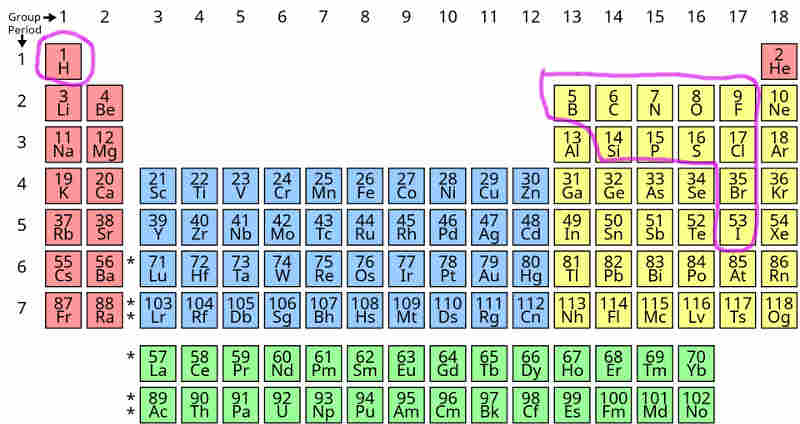

Now let's have a look at how many molecules have how many of these atoms. The x-axis in the plot goes to 200 (sadly not very readable due to some `seaborn` issues), while the y-axis has a log-scale due to the huge differences in orders of magnitude.

In [ ]:
def get_number(mystring):
    mynumbers = re.findall( '[0-9]+', mystring)
    if len(mynumbers)>0: return int(mynumbers[0])
    else: return int(1)

mydictlist = [ { re.findall( '[A-Z][a-z]*', mysubstr)[0]: [get_number(mysubstr)] for mysubstr in re.findall('[A-Z][^A-Z]*', a) }
 for a in tqdm(train_labels['chemical_notation'].values) ]

tmplist = [[0 if not(atom in mydict) else mydict[atom] for mydict in mydictlist] for atom in sorted_unique]

for idx, atom in enumerate(sorted_unique):
    train_labels[atom] = tmplist[idx]

for atom in sorted_unique:    
    train_labels[atom] = [val if not(isinstance(val, list)) else val[0] for val in train_labels[atom].values]    
    
count_data = pd.concat( [train_labels[atom].value_counts().rename_axis('atoms').reset_index(name='molecules').assign(atom=atom) for atom in sorted_unique] )
count_data['atoms'] = [mole if not(isinstance(mole, list)) else mole[0] for mole in count_data['atoms'].values]    

In [ ]:
g = sns.FacetGrid(count_data, col="atom", height=12, col_wrap=1);
g.map(sns.barplot, "atoms", "molecules").set(yscale = 'log', xticks=[i for i in range(200)]).set_xticklabels(rotation=90);

# Molecule sizes
Here's an overview of the artomic mass of the molecules:

In [ ]:
atomic_mass = {'H': 1.00797, 'B': 10.81, 'C': 12.011, 'N': 14.0067,
               'O':15.9994, 'F':18.998403, 'Si':28.0855, 'P':30.97376,
               'S':32.06, 'Cl':35.453, 'Br':79.904, 'I': 126.9045}

train_labels['atomic mass'] = atomic_mass['H']*train_labels['H'] + atomic_mass['B']*train_labels['B'] +\
    atomic_mass['C']*train_labels['C'] + atomic_mass['N']*train_labels['N'] +\
    atomic_mass['O']*train_labels['O'] + atomic_mass['F']*train_labels['F'] + \
    atomic_mass['Si']*train_labels['Si'] + atomic_mass['P']*train_labels['P'] + atomic_mass['S']*train_labels['S'] +\
    atomic_mass['Cl']*train_labels['Cl'] + atomic_mass['Br']*train_labels['Br'] + atomic_mass['I']*train_labels['I']

train_labels['Number of atoms'] = train_labels['H'] + train_labels['B'] + train_labels['C'] + train_labels['N'] +\
    train_labels['O'] + train_labels['F'] + train_labels['Si'] + train_labels['P'] + train_labels['S'] +\
    train_labels['Cl'] + train_labels['Br'] + train_labels['I']



In [ ]:
train_labels['atomic mass'].describe()

And here's an overview of the molecule size in terms of number of atoms:

In [ ]:
fewest_atoms = min(train_labels['Number of atoms'].values)
most_atoms = max(train_labels['Number of atoms'].values)
train_labels['Number of atoms'].describe()

This is the smallest molecule in the training data in terms of summed atomic weights is:

In [ ]:
train_labels[train_labels['atomic mass']<30.1]

This is the biggest one:

In [ ]:
train_labels[train_labels['atomic mass']>2.7e+03]

Some other notably big molecules are:

In [ ]:
train_labels[train_labels['atomic mass']>2e+03]

I'm not really sure that these are particularly realistic/relevant molecules, but I guess that's kind of besides the point.

The biggest and smallest molecules in terms of the total number of atoms are:

In [ ]:
train_labels[train_labels['Number of atoms'] == fewest_atoms]

In [ ]:
train_labels[train_labels['Number of atoms'] == most_atoms]

There might be an interesting relationship that the bigger the molecule, the more white area there is in a plot:

In [ ]:
image_info = pd.merge(image_info, 
                      train_labels[['image_id', 'Number of atoms', 'atomic mass']],
                      on='image_id', how='left')
sns.scatterplot(data=image_info, x='Number of atoms', y='Proportion of non-white pixels (trimmed)');
sns.scatterplot(data=image_info, x='atomic mass', y='Proportion of non-white pixels (trimmed)');

# The competition metric
 
As the overview page points out, the competition metric is the mean [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between the InChi strings you submit and the ground truth InChi values. For two string this distance is the smallest number of edits (an insertion, a deletion and a substitution of a single letter all count as one edit) that we need to make to change one string into the other string. E.g. "dog" to "cat" requires 3 edits, "dog" to "dogs" requires 1 edit, "dog" to "god" requires 2 edits, "dog" to "Cute Doggie!" needs 10 edits and "dog" to "dog" requires 0 edits.

I'm not sure whether this is really a good metric. Perhaps the sponsors might have wanted to limit how much of a penalty you can incur from a single example that you completely mess up? Because as it is the worst distance is limited only by the length of the longer of the two string (i.e. ground truth and your prediction) and there's more potential for being penalized for longer strings and less for shorter strings (unless you of course wrongly predict something very long). Furthermore, I wonder whether one could have evaluated the layers individually, although I suppose when the metric admits inserting/removing letters until the correct strings align, perhaps that is fine? In any case, let's look at what this metric does with some real InChI strings:

Firstly, two identical strings have a distance of 0.

In [ ]:
import nltk

# Two identical strings
nltk.edit_distance('InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1',
                   'InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1')

If we introduce leave out 9 letters in the connection layer, we can see that we now get a distance of 8. And this distance is symmetrical, i.e. it does not matter which string is first and which one is second:

In [ ]:
# Two times the same mistake, just in different order:
print( nltk.edit_distance('InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1',
                          'InChI=1S/C21H30O4/c1-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'))

print( nltk.edit_distance('InChI=1S/C21H30O4/c1-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1',
                         'InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'))

The distance is also 9, if instead of leaving out the 9 letters, I replace them with other letters:

In [ ]:
print( nltk.edit_distance('InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1',
                          'InChI=1S/C21H30O4/c1*********-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'))

Swapping around the order of the atoms at the start ("O4H30C21" instead of "C21H30O4") gets you a penalty of 6, but in context then the following connection layer actually does not make so much sense and means something totally different, but that's not penalized that badly in a sense:

In [ ]:
print( nltk.edit_distance('InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1',
                          'InChI=1S/O4H30C21/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1'))

# How to easily find some examples you may be looking for?

Here are 10 examples without a hydrogen layer. E.g. the first one just contain 7 carbon atoms, 5 Br and 1 nitrogen atom.

In [ ]:
[train_label for train_label in train_labels['InChI'] if "/h" in train_label][:10]

# What if I want to treat this as a language generation task (image captioning)?

This is also discussed on the forums (see [here](https://www.kaggle.com/c/bms-molecular-translation/discussion/223471)). Here's some considerations:
* Don't do things you don't need to do. Sure, you can teach a language model that every string starts with **"InChI=1S/"**, but you might just as well concatenate that on.
* You may wish to consider treating the different layers as separate prediction targets, but you probably want to find a way to reflect the interdependence between them (e.g. generating them all together may be an option). If you do a single string generation, then make sure your model is capable of "remembering" / "paying attention to" the start of the string and other sections that may have occurred a long distance away (in order to generate different layers that are consistent).
* Put a bit of domain knowledge into how you construct the vocabulary. Maybe the model can learn on its own that "B" and "r" in "Br" belong together and refer to a single atom, but is it not easier if you just tell it this information so it does not have to figure these things out? Particularly, since there's also "/r" and there's really no connection between the two "r" characters in the two contexts.
* How to deal appropriately with numbers is another good question. E.g. "-15-" refers to 15 and that this is a number - rather than the letters "1" and "5". If the model does not "know" that, it'll be somewhat harder for a model to "learn" that 15 atoms are more than 2 and a lot less than 51 (especially, if 51 never appears in the training data). I think there's a decent amount of research suggesting that language models [struggle a bit with understanding numbers when they treat them like any other word in the vocabulary, but that we can improve on that](https://arxiv.org/pdf/1805.08154). 
* Additionally, a number can mean different things in different layers of the InChI string - having a different language model that is treated as having a separate vocabulary may be a good idea. Or perhaps there's some other clever way of handling this.

Of course, we can always hope that given a large amount of training data (in a sense we have that here, but perhaps in a sense not...) a model can just figure out everything on its own, but I'd guess putting a bit of domain knowledge in must help.

# What could a tokenizer and numericalization look like?

How do we get language models to work with / output text? The typical steps involve
1. **tokenization**: Turn the text string into a list of "tokens". These are some sensible items that can be used to represent the text. In a normal sentence these could e.g. be words, some sub-words (e.g. syllables) or letters. Here, it may be more obvious to do something slightly different (see below).
2. **numericalization**: Turning the "tokens" into integers, so we can efficiently store them. Each integer then represent a single token, which an embedding layer in a model may then turn into a particular embedding.

Here, we will only deal with the chemical notation part of the target, but the similar ideas transfer to other parts of the InChI string. Default tokenizers for language do not see entirely right, as mentioned above. We presumably want to e.g. keep **Br** together as a single symbol/token (a single atom), but **CH** should end up counting as two separate tokens (i.e. a carbon atom **C** and a hydrogen atom **H**). Similarly, we need to decide what to do about numbers. One option is a tokenizer like the following, which also turns with numericalization:
* Each atom is an element in our vocabulary and maps to a number from 1 to 11. E.g. we use `2` for carbon and `5` for hydrogen (see code below). 
* The numbers indicating multiple occurences of an atom results in the atom being repeated. E.g. for C2H4 (ethylene), we would generate the tokenized sequence `CCHHHH` and turn this into the numerical list `[2,2,5,5,5,5]`. That's my attempt to work around how to deal with the numbers in the strings. We just need to make sure our code appropriately deals with the case of a single atom, where the string will not have a number.
* We also have an end of string token that we numerically represent as `12`.
* We have a padding token that we numerically represent as `13` so that we can save all the resulting processed data in a saved numpy array we can easily read (or load) into memory as needed. Perhaps you can deal with this bit differently, but it seems to work okay for me.
* If we use a list of length 10, then ethylene (C2H4) would end up being encoded as `[2,2,5,5,5,5,12,13,13,13]`. Obviously, we will have a lot more padding with the real data, because some molecules are pretty big.

After generating these outputs, we will have then to post-process them into the InChI format.

In [ ]:
# Let's free up some memory:
import gc
del train_labels, image_id, file_path, layers, train, out1, image_info, mylistlist, sorted_unique, number_of_uniques, mydictlist, tmplist, count_data, atomic_mass, fewest_atoms, most_atoms
gc.collect()

In [ ]:
import numpy as np
import pandas as pd 
import re
import fastcore
from fastcore.parallel import parallel

In [ ]:
train_data = pd.read_csv('../input/bms-molecular-translation/train_labels.csv')
layers = ['version', 'chemical_notation']
for layerid, layer in enumerate(layers):
    train_data[layer] = [ (train_data.split("/"))[layerid] for train_data in train_data['InChI']]
    
atoms=['B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si']
atomvocab={'B':0, 'Br':1, 'C':2, 'Cl':3, 'F':4, 'H':5, 'I':6, 'N':7, 'O':8, 'P':9, 'S':10, 'Si':11}
vocabatom={0:'B', 1:'Br', 2:'C', 3:'Cl', 4:'F', 5:'H', 6:'I', 7:'N', 8:'O', 9:'P', 10:'S', 11:'Si', 12:'', 13:''}

In [ ]:
def tokenize_one_letter_number(subsplit):    
    split0 = re.findall('[A-Z][a-z]*', subsplit)[0]
    split1 = re.findall('[0-9]*', subsplit)
    #print(f'{split0} :: {split1}')    
    howmany = max([int(s1) for s1 in split1 if s1!=''] + [1])
    return [atomvocab[split0]] * howmany
        
def tokenize_string(mystring):
    split = re.findall( '[A-Z][a-z]*[0-9]*', mystring)    
    return sum([tokenize_one_letter_number(subsplit) for subsplit in split], [])

# # Example of how this function works
# tokenize_string(train_data['chemical_notation'].values[0])


In [ ]:
tokenized_chemno = parallel(tokenize_string, list(train_data['chemical_notation'].values), 
                            n_workers=4, progress=True)

In [ ]:
# Pre-fill array with padding (13)
tokarr_chemno = np.full(shape=[len(tokenized_chemno),
                               max([len(tc) for tc in tokenized_chemno])+1],
                        fill_value=13, dtype=np.uint8)
for i,j in enumerate(tokenized_chemno):
    tokarr_chemno[i][0:len(j)] = j
    # Add end of string
    tokarr_chemno[i][len(j)] = 12

In [ ]:
np.save("tokarr_chemno.npy", tokarr_chemno)